
dataset: https://www.cis.upenn.edu/~jshi/ped_html/

In [1]:
import torch
import torchvision
import torchvision.tv_tensors
import torchvision.transforms.v2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = torchvision.io.read_image(img_path)
        mask = torchvision.io.read_image(mask_path)
        obj_ids = torch.unique(mask)[1:]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = torchvision.ops.masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {"boxes": torchvision.tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=torchvision.transforms.v2.functional.get_size(img)),
                "masks": torchvision.tv_tensors.Mask(masks),
                "labels": labels,
                "image_id": idx,
                "area": area,
                "iscrowd": iscrowd}

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.imgs)

In [3]:
def plot_image_masks_boxes(ax, img, masks, boxes):
    # compact all masks into a 2d array
    mask_compact = torch.zeros(size=masks.shape[1:], dtype=torch.float)
    for i in range(masks.shape[0]):
        mask_compact[masks[i,...]>0]=(i+1)/masks.shape[0]
    mask_compact = (255*mask_compact).to(dtype=torch.uint8)
    # plot image
    ax.imshow(img.permute(1,2,0))
    # plot mask
    alpha = torch.zeros_like(mask_compact, dtype=torch.float)
    alpha[mask_compact>0] = 0.6
    ax.imshow(mask_compact, alpha=alpha)
    # plot bounding boxes
    for i in range(boxes.shape[0]):
        xmin, ymin, xmax, ymax = boxes[i]
        width = xmax - xmin
        height = ymax - ymin
        rect = Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.axis("off")

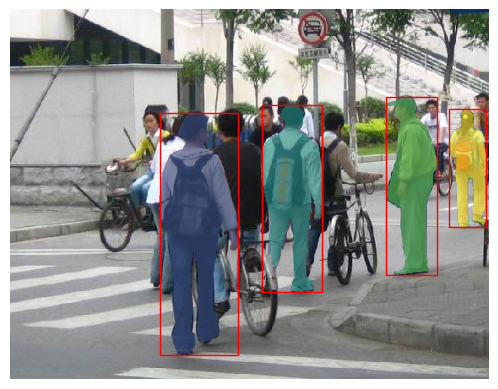

In [11]:
ds = PennFudanDataset("../datasets/PennFudanPed/", None)
dl = torch.utils.data.DataLoader(ds, batch_size=8,)
img, target = ds[45+0*np.random.randint(0, len(ds))]
ax = plt.subplot(111)
plot_image_masks_boxes(ax, img, target["masks"], target["boxes"])
plt.show()

In [5]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [6]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(torchvision.transforms.v2.RandomHorizontalFlip(0.5))
    transforms.append(torchvision.transforms.v2.ToDtype(torch.float, scale=True))
    transforms.append(torchvision.transforms.v2.ToPureTensor())
    return torchvision.transforms.v2.Compose(transforms)

In [7]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('../datasets/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1436, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0738, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0428, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0034, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [8]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('../datasets/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('../datasets/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:01:59  lr: 0.000090  loss: 3.6565 (3.6565)  loss_classifier: 0.7108 (0.7108)  loss_box_reg: 0.2871 (0.2871)  loss_mask: 2.6453 (2.6453)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 1.9858  data: 0.3039  max mem: 1945
Epoch: [0]  [10/60]  eta: 0:00:25  lr: 0.000936  loss: 1.6801 (2.2491)  loss_classifier: 0.4622 (0.4815)  loss_box_reg: 0.3116 (0.3524)  loss_mask: 0.9080 (1.3848)  loss_objectness: 0.0208 (0.0233)  loss_rpn_box_reg: 0.0073 (0.0071)  time: 0.5077  data: 0.0324  max mem: 2705
Epoch: [0]  [20/60]  eta: 0:00:16  lr: 0.001783  loss: 0.9064 (1.4890)  loss_classifier: 0.2146 (0.3287)  loss_box_reg: 0.2882 (0.2942)  loss_mask: 0.3657 (0.8395)  loss_objectness: 0.0202 (0.0199)  loss_rpn_box_reg: 0.0073 (0.0067)  time: 0.3465  data: 0.0054  max mem: 2763
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.6083 (1.1945)  loss_classifier: 0.1212 (0.2556)  loss_box_reg: 0.2352 (0.2830)  loss_mask: 0.1892 (0.6325)  loss_ob

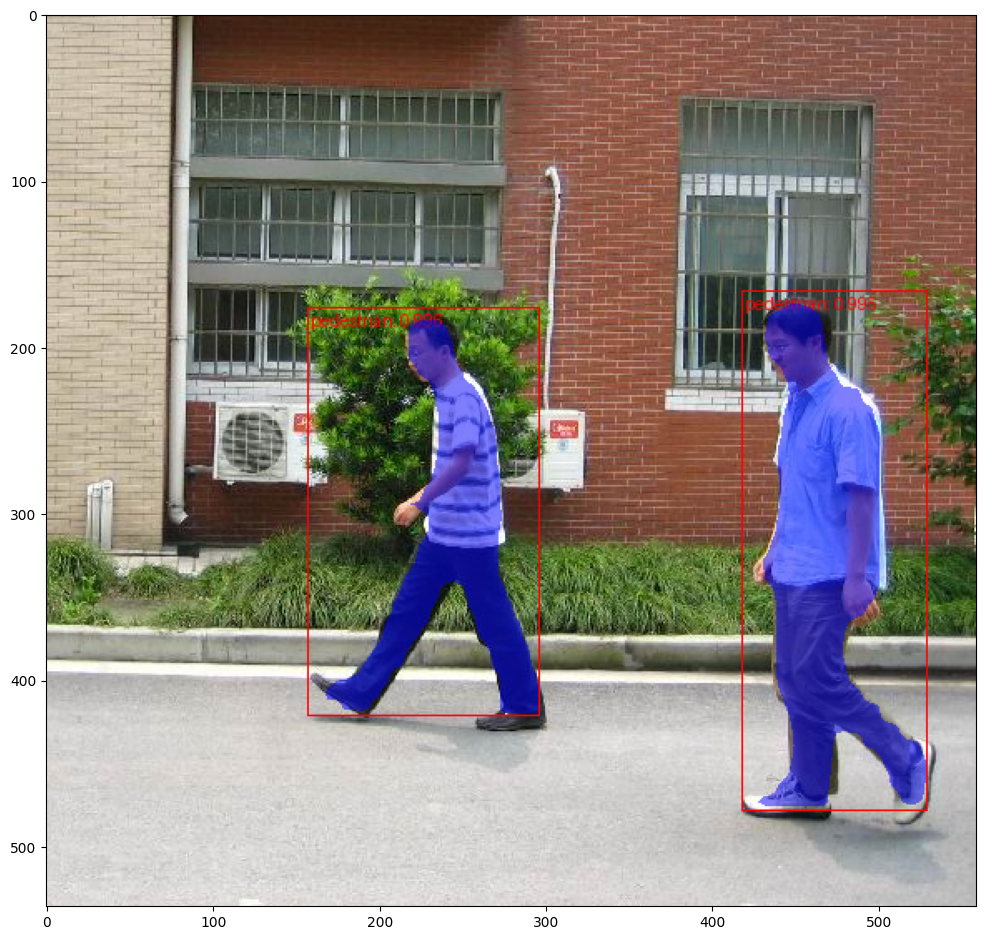

In [13]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = torchvision.io.read_image("../datasets/PennFudanPed/PNGImages/FudanPed00001.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()